# 1 Постановка задачи

**Бизнес-постановка задачи:** Реализовать систему, которая сможет оценить стоимость ноутбука.

**Постановка ML-задачи:** Линейная регрессия (для предугадывания цены ноутбука на основе различных характеристик)

**Набор данных для решения задачи:**

[Laptop Prices](https://www.kaggle.com/datasets/owm4096/laptop-prices)

- `Company:` Производитель ноутбука
- `Product:` Бренд и модель
- `TypeName:` Тип ноутбука (Notebook, Ultrabook, Gaming, …etc).
- `Inches:` Размер экрана
- `Ram:` Общий объем оперативной памяти в ноутбуке (GBs).
- `OS:` Установлена операционная система или нет.
- `Weight:` Вес ноутбука в килограммах.
- `Price_euros:` Цена ноутбука в евро. (Целевая переменная)
- `Screen:` Определение экрана (Standard, Full HD, 4K Ultra HD, Quad HD+).
- `ScreenW:` Ширина экрана (pixels).
- `ScreenH:` Высота экрана (pixels).
- `Touchscreen:` Есть ли в ноутбуке сенсорный экран
- `IPSpanel:` Имеет ли ноутбук IPS-панель.
- `RetinaDisplay:` Имеет ли ноутбук дисплей сетчатки глаза.
- `CPU_company`
- `CPU_freq:` Частота процессора ноутбука (Hz).
- `CPU_model`
- `PrimaryStorage:` первичное пространство хранения (GB).
- `PrimaryStorageType:` Тип первичного хранилища (HDD, SSD, Flash Storage, Hybrid).
- `SecondaryStorage:` Вторичное пространство для хранения, если таковое имеется (GB).
- `SecondaryStorageType:` Тип вторичного хранилища (HDD, SSD, Hybrid, None).
- `GPU_company`
- `GPU_model`

## 1.1 Импорты

In [73]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [74]:
sns.set_style("darkgrid")

## 1.2 Выбор метрик

1. $MAPE = \frac{1}{N} \sum \limits_{i=1}^{N} {\frac{\lvert y_i - f(x_i) \rvert}{\lvert y_i \rvert}}$

    **Целесообразность:** Относительная ошибка. Для оценки цен ноутбуков эта метрика поможет понять, насколько близки предсказания к реальным значениям в контексте относительных отклонений. Поскольку цены могут сильно варьироваться в зависимости от характеристик, MAPE будет полезен для сравнения точности модели при различных диапазонах цен. Например, если модель предсказывает цену ноутбука с относительной ошибкой менее 5%, это означает, что оценка достаточно точна для большинства случаев

2. $MAE = \frac{1}{N} \sum_\limits{i=1}^{N} {\lvert y_i - f(x_i) \rvert}$

    **Целесообразность:** Абсолютная ошибка. MAE измеряет среднюю величину абсолютных ошибок между предсказанными ценами ноутбуков и их фактическими значениями. Эта метрика важна, так как она предоставляет ясное представление о том, насколько точно модель оценивает стоимость ноутбуков. Для бизнеса, который стремится предлагать конкурентные цены, MAE позволит понять, насколько близко предсказанные цены соответствуют рыночным. Меньшее значение MAE укажет на то, что модель хорошо справляется с задачей оценки.

3. $MSE=\frac{1}{N} \sum_\limits{i=1}^{N} {(y_i - f(x_i))}^2$

    **Целесообразность:** MSE вычисляет среднюю величину квадратов ошибок между предсказанными и фактическими ценами. Эта метрика особенно полезна в нашем случае, поскольку она акцентирует внимание на больших ошибках. Использование MSE позволит выявить и минимизировать такие выбросы, улучшая общую точность модели.

## 1.3 Знакомство с данными

Загрузим датасет и посмотрим как он выглядит

In [75]:
path = 'laptop_prices.csv'
data = pd.read_csv(path, encoding='ISO-8859-1')

In [76]:
data.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


Вижу, что столбцы названы не совсем удобно для работы в Pandas, обработаем их

In [77]:
new_columns_name = [name.lower() for name in data.columns]
new_columns_name[2] = 'type_name'
new_columns_name[9] = 'screen_w'
new_columns_name[10] = 'screen_h'
new_columns_name[11] = 'touch_screen'
new_columns_name[12] = 'ips_panel'
new_columns_name[13] = 'retina_display'
new_columns_name[17] = 'primary_storage'
new_columns_name[18] = 'secondary_storage'
new_columns_name[19] = 'primary_storage_type'
new_columns_name[20] = 'secondary_storage_type'
data.columns = new_columns_name

In [78]:
data.head()

,company,product,type_name,inches,ram,os,weight,price_euros,screen,screen_w,...,retina_display,cpu_company,cpu_freq,cpu_model,primary_storage,secondary_storage,primary_storage_type,secondary_storage_type,gpu_company,gpu_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company                 1275 non-null   object 
 1   product                 1275 non-null   object 
 2   type_name               1275 non-null   object 
 3   inches                  1275 non-null   float64
 4   ram                     1275 non-null   int64  
 5   os                      1275 non-null   object 
 6   weight                  1275 non-null   float64
 7   price_euros             1275 non-null   float64
 8   screen                  1275 non-null   object 
 9   screen_w                1275 non-null   int64  
 10  screen_h                1275 non-null   int64  
 11  touch_screen            1275 non-null   object 
 12  ips_panel               1275 non-null   object 
 13  retina_display          1275 non-null   object 
 14  cpu_company             1275 non-null   

Заметим, что пропусков в данных нет и DTypes логически соответствуют смыслу своих колонок.

Разделим категориальные и числовые данные

In [80]:
df_num = data.select_dtypes(exclude='object')
df_cat = data.select_dtypes(include='object')

### 1.3.1 Числовые признаки

Рассмотрим числовые признаки

In [81]:
df_num.head()

,inches,ram,weight,price_euros,screen_w,screen_h,cpu_freq,primary_storage,secondary_storage
0,13.3,8,1.37,1339.69,2560,1600,2.3,128,0
1,13.3,8,1.34,898.94,1440,900,1.8,128,0
2,15.6,8,1.86,575.00,1920,1080,2.5,256,0
3,15.4,16,1.83,2537.45,2880,1800,2.7,512,0
4,13.3,8,1.37,1803.60,2560,1600,3.1,256,0


In [82]:
df_num.describe()

,inches,ram,weight,price_euros,screen_w,screen_h,cpu_freq,primary_storage,secondary_storage
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,15.022902,8.440784,2.040525,1134.969059,1900.043922,1073.904314,2.302980,444.517647,176.069020
std,1.429470,5.097809,0.669196,700.752504,493.346186,283.883940,0.503846,365.537726,415.960655
min,10.100000,2.000000,0.690000,174.000000,1366.000000,768.000000,0.900000,8.000000,0.000000
25%,14.000000,4.000000,1.500000,609.000000,1920.000000,1080.000000,2.000000,256.000000,0.000000
50%,15.600000,8.000000,2.040000,989.000000,1920.000000,1080.000000,2.500000,256.000000,0.000000
75%,15.600000,8.000000,2.310000,1496.500000,1920.000000,1080.000000,2.700000,512.000000,0.000000
max,18.400000,64.000000,4.700000,6099.000000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000


Заметим, что аномалий нет. Все числовые данные выглядят логичными.

Визуализируем числовые данные

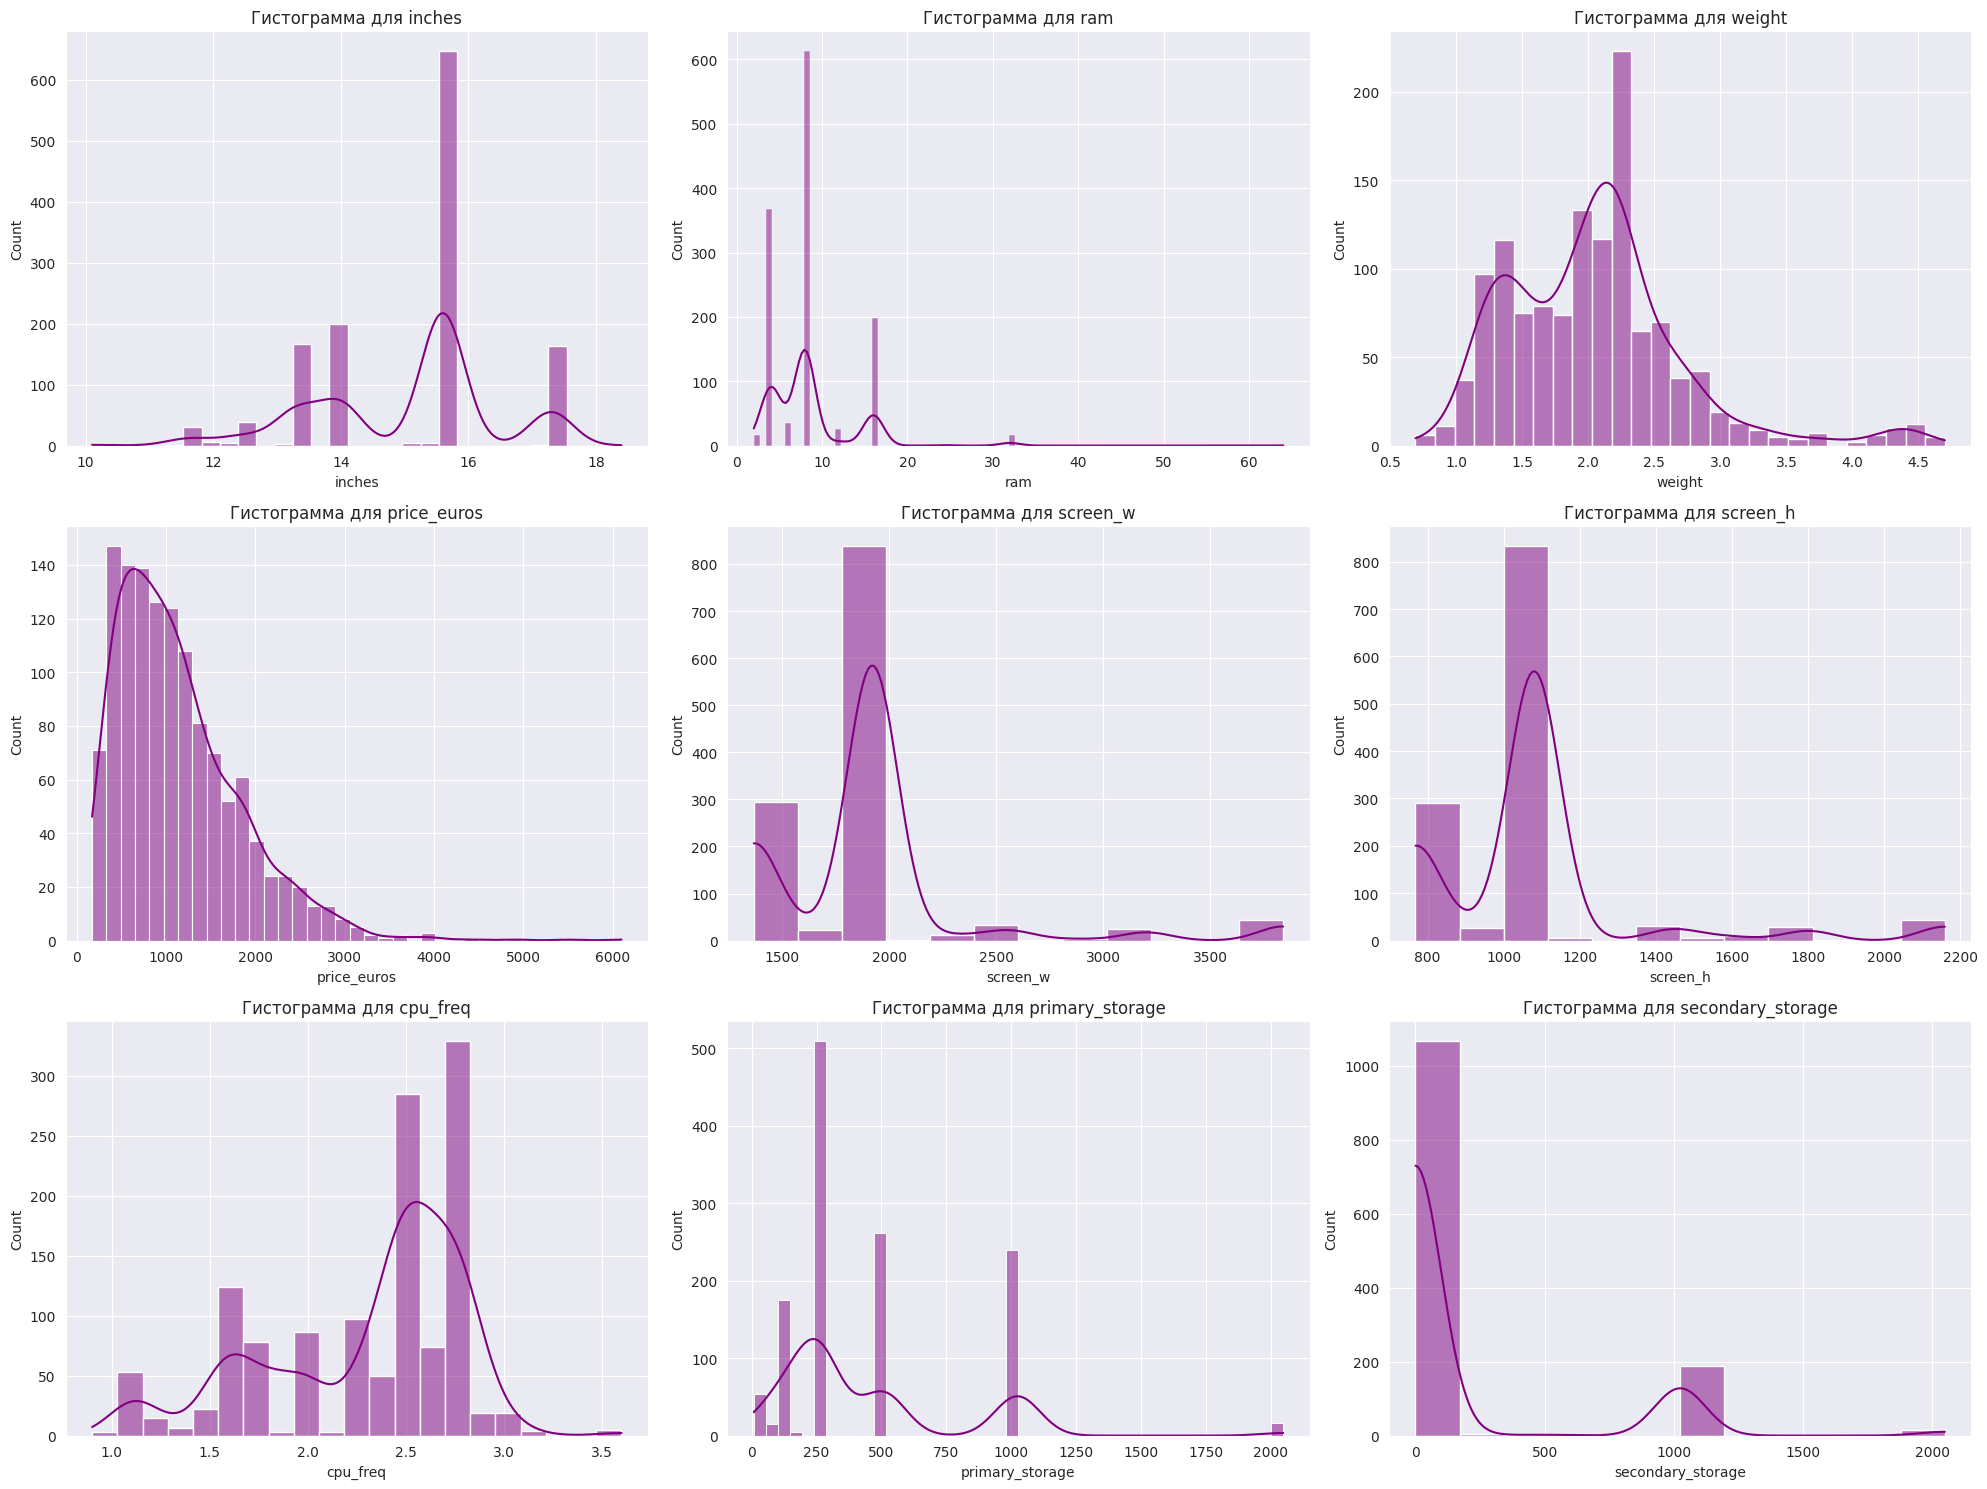

In [83]:
# Настройка размера сетки
n_cols = 3
n_rows = (df_num.shape[1] + n_cols - 1) // n_cols

# Создание фигуры и осей
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Цикл по столбцам для построения гистограмм
for i, column in enumerate(df_num.columns):
    sns.histplot(data=df_num, x=column, ax=axes[i], kde=True, color='purple')
    axes[i].set_title(f'Гистограмма для {column}')

# Удаление пустых графиков, если столбцов меньше, чем ячеек в сетке
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Показ графиков
plt.tight_layout()
plt.show()

In [84]:
for column in df_num.columns:
    mode_value = df_num[column].mode()[0]
    print(f"Мода {column}: {mode_value}")

Мода inches: 15.6
Мода ram: 8
Мода weight: 2.2
Мода price_euros: 1099.0
Мода screen_w: 1920
Мода screen_h: 1080
Мода cpu_freq: 2.5
Мода primary_storage: 256
Мода secondary_storage: 0


Построим тепловую карту, чтобы посмотреть на зависимости

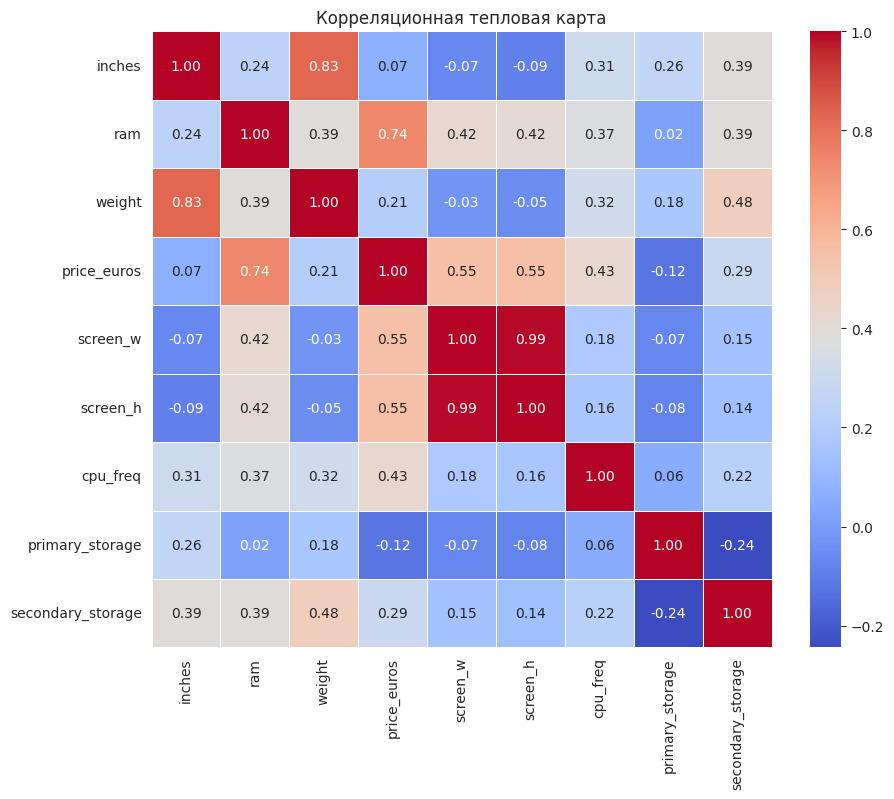

In [85]:
# Вычисление корреляционной матрицы
corr_matrix = df_num.corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная тепловая карта")
plt.show()

По тепловой карте видим, что **целевая переменная (price_euros)** сильно коррелирует с **ram**, **screen_w**, **scree_h**  и **cpu_freq**. В будущем надо будет обратить на это внимание.

Интересно, что размер экрана (inches) коррелирует с весом ноутбука (weight), что логично.

Очевидно, что высота изображения ноутбука (screen_h) коррелирует с его шириной (screen_w), так как эти переменные имеют свои взаимосвязанные стандарты.

Также заметим, что вторичное хранилище коррелирует с весом, размером экрана и ram. Достаточно логично, ведь хранилище обычно имеет ощутимый вес.

### 1.3.2 Категориальные признаки

Рассмотрим категориальные признаки

In [86]:
df_cat.head()

,company,product,type_name,os,screen,touch_screen,ips_panel,retina_display,cpu_company,cpu_model,primary_storage_type,secondary_storage_type,gpu_company,gpu_model
0,Apple,MacBook Pro,Ultrabook,macOS,Standard,No,Yes,Yes,Intel,Core i5,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,macOS,Standard,No,No,No,Intel,Core i5,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,No OS,Full HD,No,No,No,Intel,Core i5 7200U,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,macOS,Standard,No,Yes,Yes,Intel,Core i7,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,macOS,Standard,No,Yes,Yes,Intel,Core i5,SSD,No,Intel,Iris Plus Graphics 650


In [87]:
df_cat.describe()

,company,product,type_name,os,screen,touch_screen,ips_panel,retina_display,cpu_company,cpu_model,primary_storage_type,secondary_storage_type,gpu_company,gpu_model
count,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275
unique,19,618,6,9,4,2,2,2,3,93,4,4,4,110
top,Dell,XPS 13,Notebook,Windows 10,Full HD,No,No,No,Intel,Core i5 7200U,SSD,No,Intel,HD Graphics 620
freq,291,30,707,1048,835,1087,918,1258,1214,193,837,1067,704,279


Столбцы product, cpu_model и gpu_model имеют много уникальных значений, поэтмоу их визуализировать будем отдельно.

In [88]:
# Выберем столбцы для визуализации
df_cat_drop_for_viz = ['product', 'cpu_model', 'gpu_model']
df_cat_viz = df_cat.drop(columns=df_cat_drop_for_viz)

df_cat_more_uniq = df_cat[['product', 'cpu_model', 'gpu_model']]

In [89]:
# Подсчет уникальных значений для каждого столбца
product_counts = df_cat_more_uniq['product'].value_counts().reset_index()
product_counts.columns = ['product', 'count']

cpu_model_counts = df_cat_more_uniq['cpu_model'].value_counts().reset_index()
cpu_model_counts.columns = ['cpu_model', 'count']

gpu_model_counts = df_cat_more_uniq['gpu_model'].value_counts().reset_index()
gpu_model_counts.columns = ['gpu_model', 'count']

Посмотрим на популярные product, cpu_model и gpu_model

In [90]:
product_counts.head(20)

,product,count
0,XPS 13,30
1,Inspiron 3567,25
2,250 G6,21
3,Vostro 3568,19
4,Legion Y520-15IKBN,19
5,ProBook 450,18
6,Inspiron 5570,18
7,Alienware 17,15
8,Inspiron 5567,14
9,Satellite Pro,13


In [91]:
cpu_model_counts.head(20)

,cpu_model,count
0,Core i5 7200U,193
1,Core i7 7700HQ,147
2,Core i7 7500U,133
3,Core i3 6006U,81
4,Core i7 8550U,73
5,Core i5 8250U,72
6,Core i5 6200U,68
7,Core i7 6500U,43
8,Core i7 6700HQ,41
9,Core i3 7100U,35


In [92]:
gpu_model_counts.head(20)

,gpu_model,count
0,HD Graphics 620,279
1,HD Graphics 520,181
2,UHD Graphics 620,68
3,GeForce GTX 1050,66
4,GeForce GTX 1060,48
5,GeForce 940MX,43
6,Radeon 530,41
7,HD Graphics 500,39
8,HD Graphics 400,33
9,GeForce GTX 1070,30


Посмотрим на уникальные значения каждого столбца.

In [93]:
for column in df_cat_viz.columns:
    unique_values = df_cat_viz[column].unique()  # Получаем уникальные значения
    print(f"Уникальные значения для {column}: {unique_values}\n")

Уникальные значения для company: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']

Уникальные значения для type_name: ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']

Уникальные значения для os: ['macOS' 'No OS' 'Windows 10' 'Mac OS X' 'Linux' 'Android' 'Windows 10 S'
 'Chrome OS' 'Windows 7']

Уникальные значения для screen: ['Standard' 'Full HD' 'Quad HD+' '4K Ultra HD']

Уникальные значения для touch_screen: ['No' 'Yes']

Уникальные значения для ips_panel: ['Yes' 'No']

Уникальные значения для retina_display: ['Yes' 'No']

Уникальные значения для cpu_company: ['Intel' 'AMD' 'Samsung']

Уникальные значения для primary_storage_type: ['SSD' 'Flash Storage' 'HDD' 'Hybrid']

Уникальные значения для secondary_storage_type: ['No' 'HDD' 'SSD' 'Hybrid']

Уникальные значения для gpu_company: ['Intel' 'AMD' 'Nvidia' 'ARM']



Визуализируем категориальные признаки

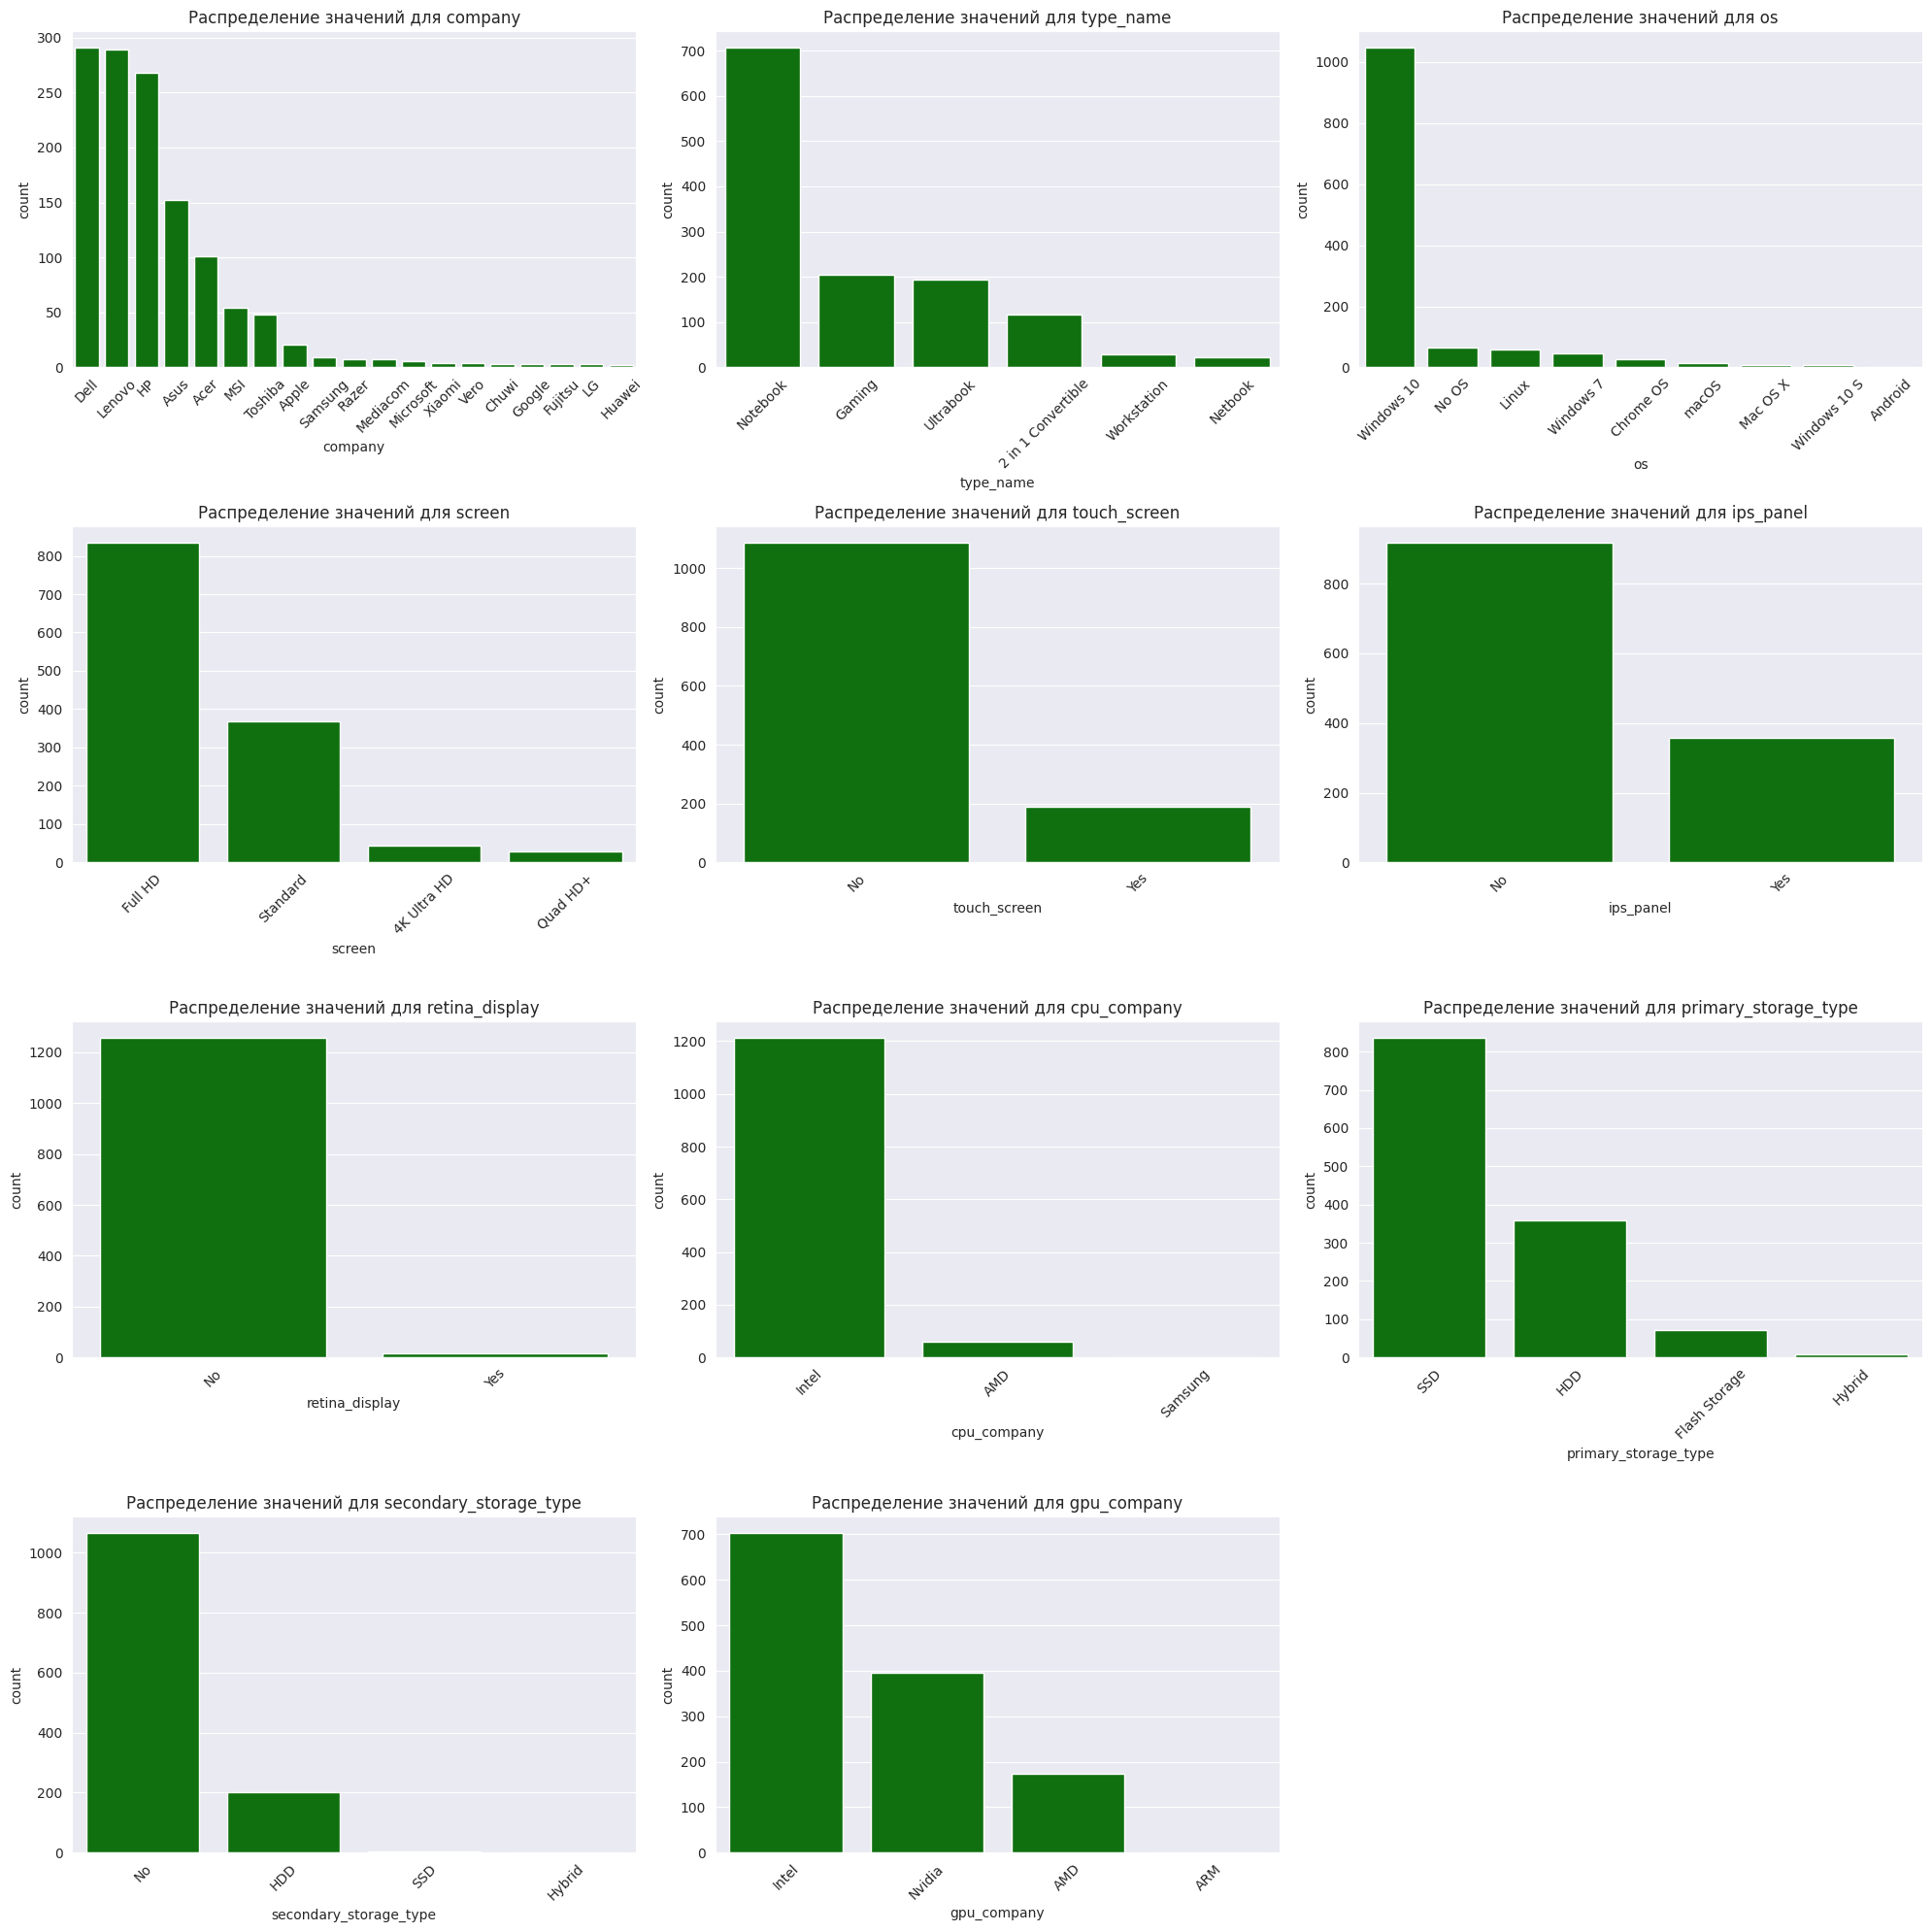

In [94]:
# Настройка размера сетки
n_cols = 3  # Количество графиков в строке
n_rows = (df_cat_viz.shape[1] + n_cols - 1) // n_cols  # Количество строк

# Создание фигуры и осей
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Превращаем массив осей в плоский список для удобства

# Цикл по столбцам для построения столбчатых графиков
for i, column in enumerate(df_cat_viz.columns):
    sns.countplot(data=df_cat_viz, x=column, ax=axes[i], order=df_cat_viz[column].value_counts().index, color='green')
    axes[i].set_title(f'Распределение значений для {column}')
    axes[i].tick_params(axis='x', rotation=45)  # Поворот подписей по оси x для удобства

# Удаление пустых графиков, если столбцов меньше, чем ячеек в сетке
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Показ графиков
plt.tight_layout()
plt.show()

Заметим, что:
- очень есть компании-производители, чьих ноутбуков очень мало;
- почти все OS это Windows 10, но есть и некоторые почти единичные случаи использования других OS;
- ноутбуков с retina_display почти нет. CPU от Samsung почти нет;
- тип главного хранилища Hybrid носит почти единичный характер;
- тип второго вторичного хранилища имеет единичные случаи SSD и Hybrid;
- GPU от ARM носит единичный характер.